In [ ]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torch.utils.checkpoint as checkpoint
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from skorch import NeuralNetClassifier
from collections import Counter
import warnings
from torchsummary import summary

warnings.filterwarnings('ignore')

In [ ]:
base_dir = 'D:/99_MLP classification/data/'
con = ['adt', 'lh', 'rh', 'vis']

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')
print ("device: [%s]"%(device))

device: [cuda:0]


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_paths, mapped_labels, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for file_path, label in zip(data_paths, mapped_labels):
            data_df = pd.read_csv(file_path, index_col = 'Unnamed: 0')

            for col in data_df.columns:
                data_col = data_df[col].values
                data_tensor = torch.tensor(data_col, dtype=torch.float)
                self.data.append(data_tensor)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [ ]:
data_paths = []
labels = []
ex_labels = []
label_mapping = {'lh': 0, 'rh': 1, 'adt': 2, 'vis': 3}

for label_name, label_id in label_mapping.items():
    label_path = os.path.join(base_dir, label_name)
    if os.path.isdir(label_path):
        for excel_file in glob.glob(label_path + '/*.csv'):
            file_path = os.path.join(label_path, excel_file)
            data = pd.read_csv(file_path, index_col = 'Unnamed: 0')
            num_columns = len(data.columns)
            # data_paths.extend([file_path] * num_columns)
            data_paths.append(file_path)
            ex_labels.extend([label_id] * num_columns)
            labels.append(label_id)

# train_paths, test_paths, train_labels, test_labels = train_test_split(
#     data_paths, labels, test_size=0.2, stratify=labels, random_state=123)

all_dataset = CustomDataset(data_paths, labels)
train_dataset, test_dataset = train_test_split(all_dataset, test_size = 0.2, stratify = ex_labels, random_state = 123)

In [ ]:
class MLP(nn.Module):
    def __init__(self, inp, hidden1=100, hidden2 = 50):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(inp, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ELU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ELU()
        )
        self.fc3 = nn.Linear(hidden2, 4)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def compute_l1(self, w):
        return torch.abs(w).sum()

def input_size(data_loader):
    for data, _ in data_loader:
        return data.view(data.size(0), -1).shape[1]

model = MLP(inp = (62766)).to(device)

# print(model)

summary(model, (1, 62766))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 62766]               0
            Linear-2                  [-1, 100]       6,276,700
       BatchNorm1d-3                  [-1, 100]             200
               ELU-4                  [-1, 100]               0
            Linear-5                   [-1, 50]           5,050
       BatchNorm1d-6                   [-1, 50]             100
               ELU-7                   [-1, 50]               0
           Dropout-8                   [-1, 50]               0
            Linear-9                    [-1, 4]             204
Total params: 6,282,254
Trainable params: 6,282,254
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.24
Forward/backward pass size (MB): 0.48
Params size (MB): 23.96
Estimated Total Size (MB): 24.69
-------------------------------------

In [ ]:
def train(dataloader, model, loss_fn, optimizer, l1 = False, l1_weight = 1):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()

        if l1:
            l1_parameters = []
            for parameter in model.parameters():
                l1_parameters.append(parameter.view(-1))
            l1 = l1_weight * model.compute_l1(torch.cat(l1_parameters))
            loss += l1

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(pred, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

    avg_train_loss = train_loss / len(dataloader)
    train_accuracy = correct / total

    return avg_train_loss, train_accuracy


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            _, predicted = torch.max(pred, 1)
            correct += (predicted == y).sum().item()

    avg_test_loss = test_loss / num_batches
    test_accuracy = correct / size

    # print(f"Test Error: \n Accuracy: {(100 * test_accuracy):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")

    return avg_test_loss, test_accuracy


In [ ]:
def plot_metrics(train_losses, train_accuracies, test_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### L2 regularization

In [ ]:
# k_folds = 5
# skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=123)

# fold_train_losses, fold_train_accuracies = [], []
# fold_test_losses, fold_test_accuracies = [], []

# epochs = 100; batch_size = 10

# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# train_data = [train_dataset[i][0] for i in range(len(train_dataset))]
# train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]

# param_grid = {
#     'lr': [1e-3, 1e-4, 1e-5],
#     'weight_decay': [1e-5, 1e-4],
#     'hidden1': [50, 100],
#     'hidden2': [25, 50]
# }

# input_size = train_dataset[0][0].shape[0]

# grid_search = GridSearchCV(
#     estimator=NeuralNetClassifier(MLP(inp=input_size)),
#     param_grid=param_grid,
#     cv=5,
#     scoring='accuracy',
#     verbose=2,
#     n_jobs=1
# )

# grid_search.fit(train_data, train_labels)

# print("\nBest Parameters:")
# print(grid_search.best_params_)
# print(f"Best Accuracy: {grid_search.best_score_ * 100:.2f}%")

# print("\nParameters:")
# for params, mean_score, _ in grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score']:
#     print(f"Params: {params}, Accuracy: {mean_score * 100:.2f}%")

# grid_search.best_estimator_.predict(test_loader)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


ValueError: Invalid parameter 'hidden1' for estimator <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=MLP(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Sequential(
      (0): Linear(in_features=62766, out_features=100, bias=True)
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
    )
    (fc2): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
    )
    (fc3): Linear(in_features=50, out_features=4, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  ),
). Valid parameters are: ['module', 'criterion', 'optimizer', 'lr', 'max_epochs', 'batch_size', 'iterator_train', 'iterator_valid', 'dataset', 'train_split', 'callbacks', 'predict_nonlinearity', 'warm_start', 'verbose', 'device', 'compile', 'use_caching', '_params_to_validate', 'classes'].

In [ ]:
from itertools import product
from collections import defaultdict
import numpy as np

epochs = 100; batch_size = 10

param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'weight_decay': [1e-5, 1e-4],
    'hidden1': [50, 100],
    'hidden2': [25, 50]
}

param_combinations = list(product(param_grid['lr'], param_grid['weight_decay'], param_grid['hidden1'], param_grid['hidden2']))

param_results = defaultdict(list)

for fold, (train_idx, test_idx) in enumerate(skf.split(train_data, train_labels)):
    print(f"Fold {fold + 1}/{k_folds}")
    print("-------------------------------")

    X_train = [train_data[i] for i in train_idx]
    y_train = [train_labels[i] for i in train_idx]
    X_test = [train_data[i] for i in test_idx]
    y_test = [train_labels[i] for i in test_idx]

    for lr, weight_decay, hidden1, hidden2 in param_combinations:
        input_size = len(X_train[0])
        model = MLP(inp=input_size, hidden1=hidden1, hidden2=hidden2).to(device)
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_fn = nn.CrossEntropyLoss()

        dataset = [(torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(y_, dtype=torch.long).to(device)) for x, y_ in zip(X_train, y_train)]
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            train(train_loader, model, loss_fn, optimizer)

        accuracy = pytorch_scorer({'model': model}, X_test, y_test)
        param_results[(lr, weight_decay, hidden1, hidden2)].append(accuracy)

avg_results = {params: np.mean(accs) for params, accs in param_results.items()}

sorted_results = sorted(avg_results.items(), key=lambda x: x[1], reverse=True)

print("\nAll Hyperparameter Combinations:")
print("-------------------------------")
for params, avg_acc in sorted_results:
    print(f"Parameters: lr={params[0]}, weight_decay={params[1]}, hidden1={params[2]}, hidden2={params[3]} | Average Accuracy: {avg_acc * 100:.2f}%")

best_params = sorted_results[0][0]
best_accuracy = sorted_results[0][1]
print("\nBest Parameters:")
print("-------------------------------")
print(f"lr={best_params[0]}, weight_decay={best_params[1]}, hidden1={best_params[2]}, hidden2={best_params[3]} | Average Accuracy: {best_accuracy * 100:.2f}%")


Fold 1/5
-------------------------------
Fold 2/5
-------------------------------
Fold 3/5
-------------------------------
Fold 4/5
-------------------------------
Fold 5/5
-------------------------------

All Hyperparameter Combinations:
-------------------------------
Parameters: lr=1e-05, weight_decay=1e-05, hidden1=100, hidden2=25 | Average Accuracy: 98.54%
Parameters: lr=1e-05, weight_decay=1e-05, hidden1=100, hidden2=50 | Average Accuracy: 98.54%
Parameters: lr=1e-05, weight_decay=0.0001, hidden1=100, hidden2=50 | Average Accuracy: 97.85%
Parameters: lr=1e-05, weight_decay=0.0001, hidden1=50, hidden2=50 | Average Accuracy: 97.64%
Parameters: lr=1e-05, weight_decay=1e-05, hidden1=50, hidden2=25 | Average Accuracy: 97.50%
Parameters: lr=0.0001, weight_decay=1e-05, hidden1=50, hidden2=50 | Average Accuracy: 97.43%
Parameters: lr=1e-05, weight_decay=1e-05, hidden1=50, hidden2=50 | Average Accuracy: 97.43%
Parameters: lr=0.0001, weight_decay=1e-05, hidden1=100, hidden2=50 | Average Ac


Training Final Model with Best Parameters:
-------------------------------


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]

Test Accuracy with Best Parameters: 99.51%


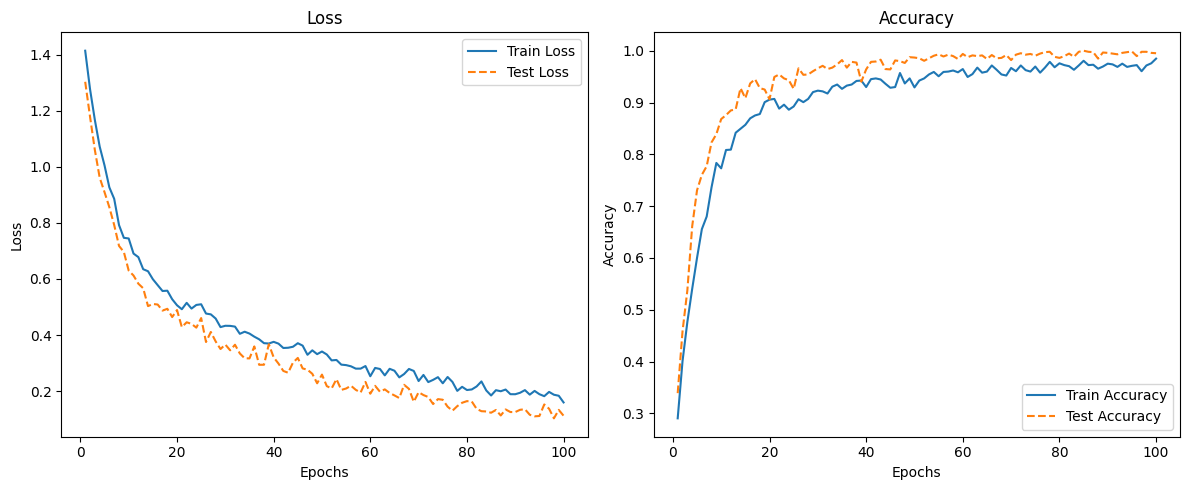

In [ ]:
print("\nTraining Final Model with Best Parameters:")
print("-------------------------------")

best_lr, best_weight_decay, best_hidden1, best_hidden2 = best_params
final_model = MLP(inp=len(train_data[0]), hidden1=best_hidden1, hidden2=best_hidden2).to(device)
final_optimizer = Adam(final_model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
loss_fn = nn.CrossEntropyLoss()

final_dataset = [(torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(y_, dtype=torch.long).to(device)) for x, y_ in zip(train_data, train_labels)]
final_train_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)

train_losses_all, train_accuracies_all = [], []
test_losses_all, test_accuracies_all = [], []

for epoch in tqdm(range(epochs)):
    train_loss, train_accuracy = train(final_train_loader, final_model, loss_fn, final_optimizer)
    train_losses_all.append(train_loss)
    train_accuracies_all.append(train_accuracy)

    test_loss, test_accuracy = test(final_train_loader, final_model, loss_fn)
    test_losses_all.append(test_loss)
    test_accuracies_all.append(test_accuracy)

print(f"Test Accuracy with Best Parameters: {test_accuracy * 100:.2f}%")

plot_metrics(train_losses_all, train_accuracies_all, test_losses_all, test_accuracies_all)

### L1 regularization

In [ ]:
from itertools import product
from collections import defaultdict
import numpy as np

epochs = 100; batch_size = 10

param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'l1_weight': [1e-6, 1e-5],
    'hidden1': [50, 100],
    'hidden2': [25, 50]
}

param_combinations = list(product(param_grid['lr'], param_grid['l1_weight'], param_grid['hidden1'], param_grid['hidden2']))

param_results = defaultdict(list)

for fold, (train_idx, test_idx) in enumerate(skf.split(train_data, train_labels)):
    print(f"Fold {fold + 1}/{k_folds}")
    print("-------------------------------")

    X_train = [train_data[i] for i in train_idx]
    y_train = [train_labels[i] for i in train_idx]
    X_test = [train_data[i] for i in test_idx]
    y_test = [train_labels[i] for i in test_idx]

    for lr, l1_weight, hidden1, hidden2 in param_combinations:
        input_size = len(X_train[0])
        model = MLP(inp=input_size, hidden1=hidden1, hidden2=hidden2).to(device)
        optimizer = Adam(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()

        dataset = [(torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(y_, dtype=torch.long).to(device)) for x, y_ in zip(X_train, y_train)]
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            train(train_loader, model, loss_fn, optimizer, l1 = True, l1_weight = l1_weight)

        accuracy = pytorch_scorer({'model': model}, X_test, y_test)
        param_results[(lr, weight_decay, hidden1, hidden2)].append(accuracy)

avg_results = {params: np.mean(accs) for params, accs in param_results.items()}

sorted_results = sorted(avg_results.items(), key=lambda x: x[1], reverse=True)

print("\nAll Hyperparameter Combinations:")
print("-------------------------------")
for params, avg_acc in sorted_results:
    print(f"Parameters: lr={params[0]}, weight_decay={params[1]}, hidden1={params[2]}, hidden2={params[3]} | Average Accuracy: {avg_acc * 100:.2f}%")

best_params = sorted_results[0][0]
best_accuracy = sorted_results[0][1]
print("\nBest Parameters:")
print("-------------------------------")
print(f"lr={best_params[0]}, weight_decay={best_params[1]}, hidden1={best_params[2]}, hidden2={best_params[3]} | Average Accuracy: {best_accuracy * 100:.2f}%")

Fold 1/5
-------------------------------
Fold 2/5
-------------------------------
Fold 3/5
-------------------------------
Fold 4/5
-------------------------------
Fold 5/5
-------------------------------

All Hyperparameter Combinations:
-------------------------------
Parameters: lr=1e-05, weight_decay=1e-06, hidden1=100, hidden2=50 | Average Accuracy: 97.99%
Parameters: lr=1e-05, weight_decay=1e-06, hidden1=100, hidden2=25 | Average Accuracy: 97.64%
Parameters: lr=1e-05, weight_decay=1e-06, hidden1=50, hidden2=25 | Average Accuracy: 97.53%
Parameters: lr=1e-05, weight_decay=1e-06, hidden1=50, hidden2=50 | Average Accuracy: 97.47%
Parameters: lr=0.0001, weight_decay=1e-06, hidden1=100, hidden2=25 | Average Accuracy: 96.91%
Parameters: lr=0.0001, weight_decay=1e-06, hidden1=50, hidden2=25 | Average Accuracy: 96.63%
Parameters: lr=0.0001, weight_decay=1e-06, hidden1=50, hidden2=50 | Average Accuracy: 95.73%
Parameters: lr=0.0001, weight_decay=1e-06, hidden1=100, hidden2=50 | Average Ac


Training Final Model with Best Parameters:
-------------------------------


100%|██████████| 100/100 [00:28<00:00,  3.49it/s]

Test Accuracy with Best Parameters: 98.89%


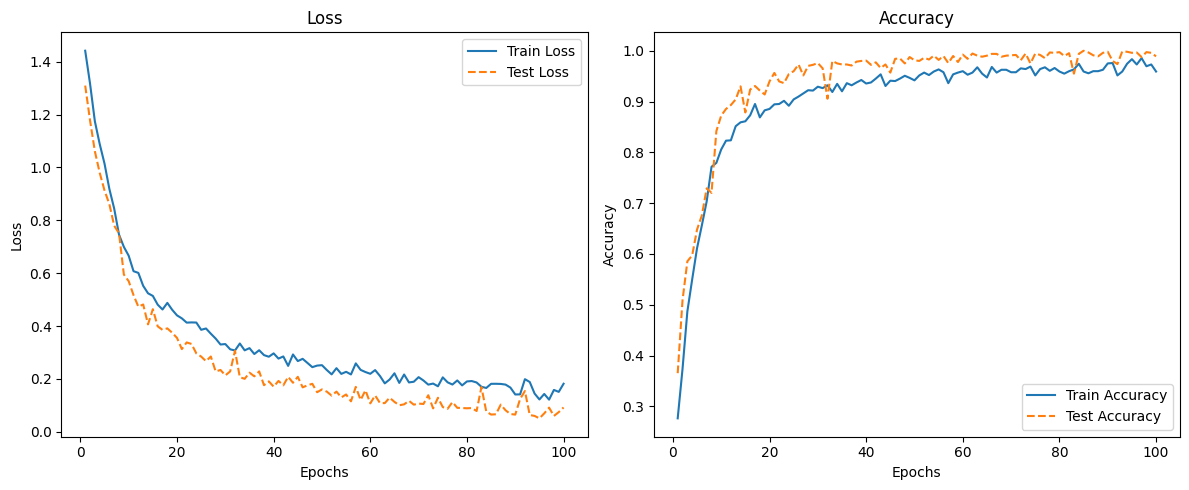

In [ ]:
print("\nTraining Final Model with Best Parameters:")
print("-------------------------------")

best_lr, best_l1_weight, best_hidden1, best_hidden2 = best_params
final_model = MLP(inp=len(train_data[0]), hidden1=best_hidden1, hidden2=best_hidden2).to(device)
final_optimizer = Adam(final_model.parameters(), lr=best_lr)
loss_fn = nn.CrossEntropyLoss()

final_dataset = [(torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(y_, dtype=torch.long).to(device)) for x, y_ in zip(train_data, train_labels)]
final_train_loader = DataLoader(final_dataset, batch_size=batch_size, shuffle=True)

train_losses_all, train_accuracies_all = [], []
test_losses_all, test_accuracies_all = [], []

for epoch in tqdm(range(epochs)):
    train_loss, train_accuracy = train(final_train_loader, final_model, loss_fn, final_optimizer, l1=True, l1_weight=best_l1_weight)
    train_losses_all.append(train_loss)
    train_accuracies_all.append(train_accuracy)

    test_loss, test_accuracy = test(final_train_loader, final_model, loss_fn)
    test_losses_all.append(test_loss)
    test_accuracies_all.append(test_accuracy)

print(f"Test Accuracy with Best Parameters: {test_accuracy * 100:.2f}%")

plot_metrics(train_losses_all, train_accuracies_all, test_losses_all, test_accuracies_all)